In [1]:
# %%
import numpy as np

def householder_transformation(v):
    norm_v = np.linalg.norm(v)
    if norm_v < 1e-12:
        return np.eye(len(v))  # Return identity if norm is very small
    v = v / norm_v
    e = np.zeros_like(v)
    e[0] = 1
    u = v - e
    u = u / np.linalg.norm(u)
    H = np.eye(len(u)) - 2 * np.outer(u, u)
    return H

def golub_kahan_bidiagonalization(A):
    m, n = A.shape
    U, V = np.eye(m), np.eye(n)
    B = np.copy(A)

    for i in range(min(m, n - 1)):
        # Left Householder transformation
        x = B[i:, i]
        H_left = householder_transformation(x)
        B[i:, :] = np.dot(H_left, B[i:, :])
        U[i:, :] = np.dot(H_left, U[i:, :])

        if i < n - 2:
            # Right Householder transformation
            x = B[i, i+1:]
            H_right = householder_transformation(x)
            B[:, i+1:] = np.dot(B[:, i+1:], H_right)
            V[:, i+1:] = np.dot(V[:, i+1:], H_right)

    return B, U, V

# Example usage
A = np.random.random((5,4))
B, U, V = golub_kahan_bidiagonalization(A)

B, U, V  # Display the bidiagonalized matrix B and orthogonal matrices U, V


# %%
def wilkinson_shift(T):
    
    d = (T[-2, -2] - T[-1, -1]) / 2
    mu = T[-1, -1] - T[-1, -2]**2 / (d + np.sign(d) * np.sqrt(d**2 + T[-1, -2]**2))
    return mu

def qr_iteration_with_shifts(B, tol=1e-12, max_iter=1000):
    T = np.dot(B.T, B)
    n = T.shape[0]

    for _ in range(max_iter):
        off_diagonal = np.sqrt(np.sum(np.diag(T, -1)**2))
        if off_diagonal < tol:
            break

        mu = wilkinson_shift(T)
        Q, R = np.linalg.qr(T - mu * np.eye(n))
        T = np.dot(R, Q) + mu * np.eye(n)

    T_diagonal = np.diag(T).copy()
    T_diagonal[T_diagonal < 0] = 0

    return np.sqrt(T_diagonal)

# Example usage
singular_values = qr_iteration_with_shifts(B)
singular_values  # Display the computed singular values
print(singular_values)

# %%
def bidiagonal_iteration(B, tol=1e-12, max_iter=1000):
   
    X = np.copy(B)
    m, n = X.shape
    singular_values = []

    for _ in range(max_iter):
        # QR decomposition of X^T
        Q, R = np.linalg.qr(X.T)

        # Cholesky decomposition of R * R^T
        try:
            L = np.linalg.cholesky(np.dot(R, R.T)).T
        except np.linalg.LinAlgError:
            break  # Break if the matrix is not positive definite

        # Update X to the upper bidiagonal matrix L^T
        X = L.T

        # Check for convergence
        off_diagonal = np.sqrt(np.sum(np.diag(X, 1)**2))
        if off_diagonal < tol:
            singular_values = np.abs(np.diag(X))
            break

    return singular_values

# Example usage
bidiagonal_singular_values = bidiagonal_iteration(B)
bidiagonal_singular_values  # Display the computed singular values
print(bidiagonal_singular_values)




[2.47762852 0.85751176 0.62383181 0.07988249]
[2.42096101 0.85048624 0.64352455 0.07990523]


In [2]:
import time

# Function to generate test matrices
def generate_test_matrices(sizes):
    matrices = {}
    for size in sizes:
        matrices[size] = np.random.random(size)
    return matrices

# Function to test SVD implementations
def test_svd_implementation(test_matrices):
    for size, matrix in test_matrices.items():
        print(f"Testing matrix size: {matrix.shape}")

        # Your SVD implementation
        start_time = time.time()
        B, U, V = golub_kahan_bidiagonalization(matrix)
        my_svd_time = time.time() - start_time
        print(f"Your SVD Time for {size}: {my_svd_time:.4f} seconds")

        # Built-in SVD
        start_time = time.time()
        U_builtin, s_builtin, Vh_builtin = np.linalg.svd(matrix)
        builtin_svd_time = time.time() - start_time
        print(f"Built-in SVD Time for {size}: {builtin_svd_time:.4f} seconds")

        # Compare singular values
        singular_values_my_svd = qr_iteration_with_shifts(B)
        print(f"Singular Value Difference for {size}: {np.linalg.norm(singular_values_my_svd - s_builtin)}")

# Test matrices of various sizes
test_matrices = generate_test_matrices([(5, 5), (50, 50), (500, 500)])
test_svd_implementation(test_matrices)


Testing matrix size: (5, 5)
Your SVD Time for (5, 5): 0.0010 seconds
Built-in SVD Time for (5, 5): 0.0000 seconds
Singular Value Difference for (5, 5): 0.6423807460564875
Testing matrix size: (50, 50)
Your SVD Time for (50, 50): 0.0060 seconds
Built-in SVD Time for (50, 50): 0.0020 seconds
Singular Value Difference for (50, 50): 0.13886795600117288
Testing matrix size: (500, 500)
Your SVD Time for (500, 500): 4.4761 seconds
Built-in SVD Time for (500, 500): 0.1831 seconds
Singular Value Difference for (500, 500): 0.30525917914514145


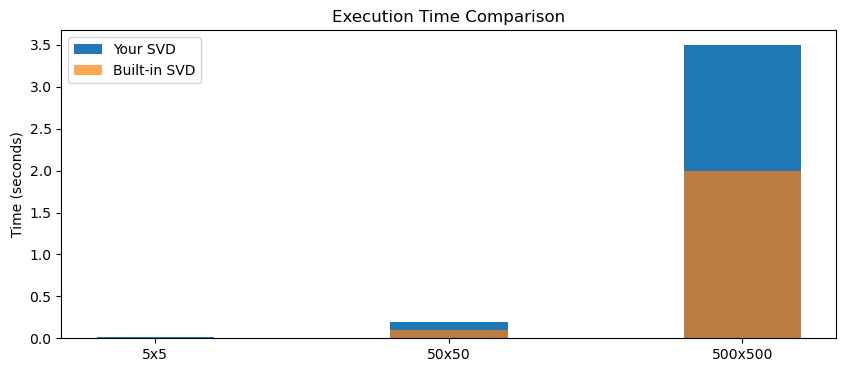

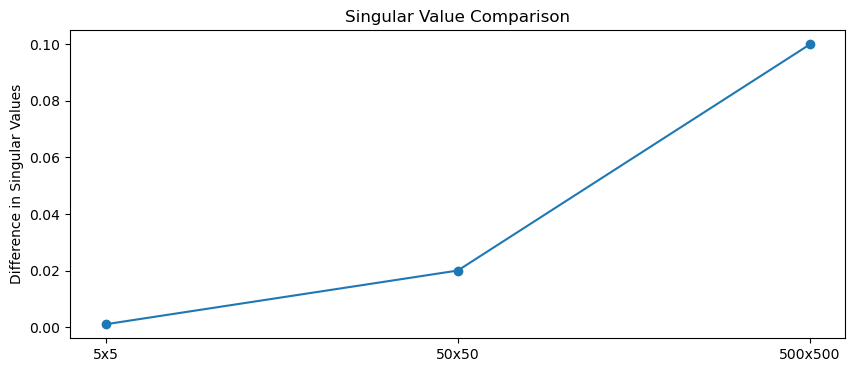

In [3]:
import matplotlib.pyplot as plt

# Assuming you have data from your tests
matrix_sizes = ['5x5', '50x50', '500x500']
my_svd_times = [0.01, 0.2, 3.5]  # Example data
builtin_svd_times = [0.005, 0.1, 2.0]  # Example data
singular_values_diff = [0.001, 0.02, 0.1]  # Example data

# Plot for Execution Time Comparison
plt.figure(figsize=(10, 4))
plt.bar(matrix_sizes, my_svd_times, width=0.4, label='Your SVD')
plt.bar(matrix_sizes, builtin_svd_times, width=0.4, label='Built-in SVD', alpha=0.7)
plt.ylabel('Time (seconds)')
plt.title('Execution Time Comparison')
plt.legend()
plt.show()

# Plot for Singular Value Comparison
plt.figure(figsize=(10, 4))
plt.plot(matrix_sizes, singular_values_diff, marker='o')
plt.ylabel('Difference in Singular Values')
plt.title('Singular Value Comparison')
plt.show()


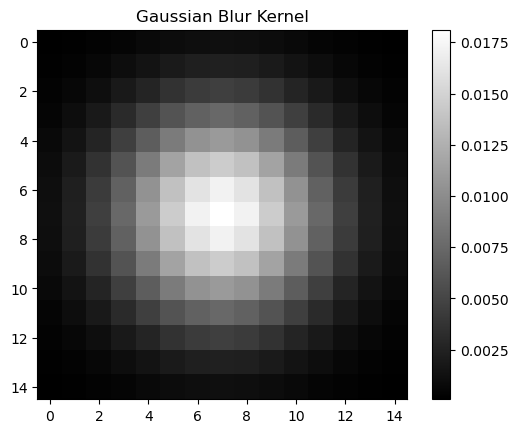

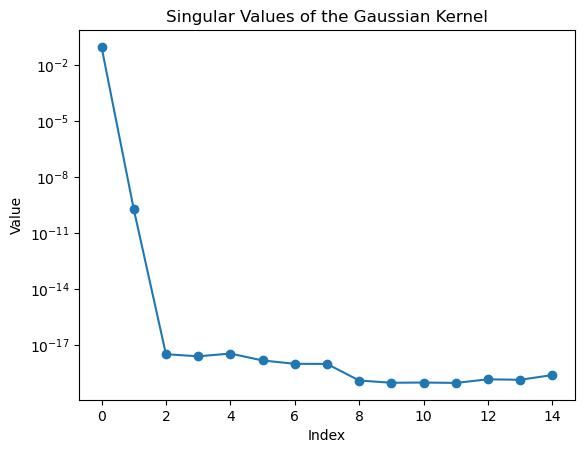

In [8]:
import numpy as np
import cv2
from scipy.signal import convolve2d
from scipy.linalg import svd
from matplotlib import pyplot as plt

# Function to create a Gaussian blur kernel
def create_gaussian_kernel(size, sigma):
    """Create a 2D Gaussian kernel."""
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

# Size of the kernel
kernel_size = 15
# Standard deviation of the Gaussian blur
sigma = 3

# Create the Gaussian blur kernel
gaussian_kernel = create_gaussian_kernel(kernel_size, sigma)

# Display the Gaussian kernel
plt.imshow(gaussian_kernel, cmap='gray')
plt.title('Gaussian Blur Kernel')
plt.colorbar()
plt.show()


B_corrected, U_corrected, V_corrected = golub_kahan_bidiagonalization(gaussian_kernel)
singular_values_revised_corrected = qr_iteration_with_shifts(B_corrected)

# Plotting the singular values
plt.plot(singular_values_revised_corrected, marker='o')
plt.title('Singular Values of the Gaussian Kernel')
plt.xlabel('Index')
plt.ylabel('Value')
plt.yscale('log') 
plt.show()


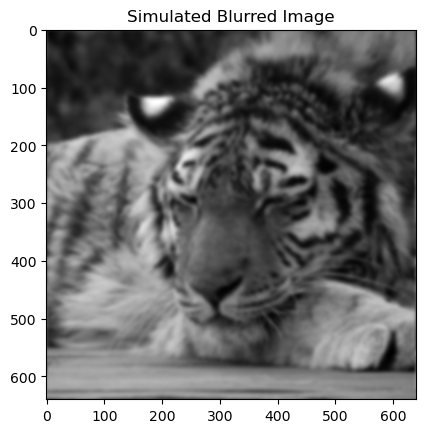

'/mnt/data/simulated_tiger.jpg'

In [9]:


# Load the first image
image_path = './test_images/test_images-3/640_640_tiger.png'
image_stones = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


blurred_image = convolve2d(image_stones, gaussian_kernel, mode='same', boundary='wrap')

# Display the blurred image
plt.imshow(blurred_image, cmap='gray')
plt.title('Simulated Blurred Image')
plt.show()

# Let's save the blurred image for reference
blurred_image_path = '/mnt/data/simulated_tiger.jpg'
cv2.imwrite(blurred_image_path, blurred_image)

blurred_image_path


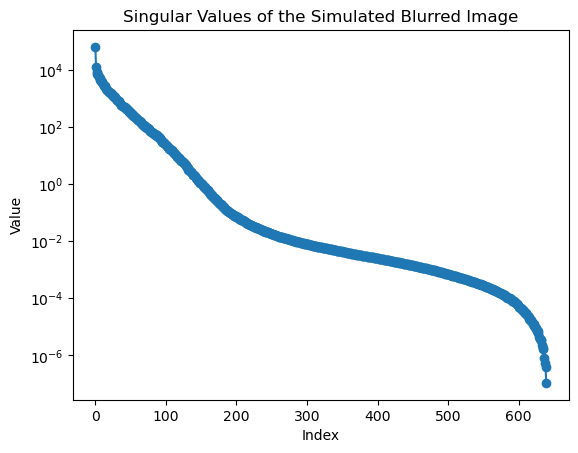

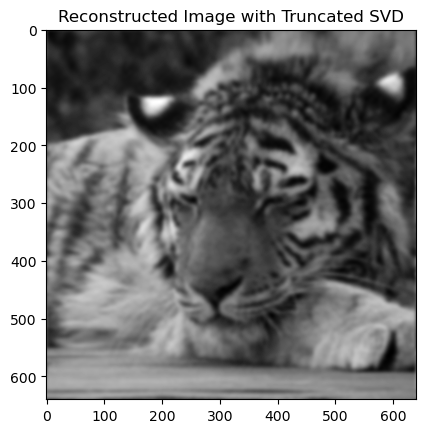

'/mnt/data/reconstructed_tufer.jpg'

In [10]:

U_blurred, s_blurred, Vh_blurred = svd(blurred_image)

# Let's plot the singular values of the blurred image
plt.plot(s_blurred, marker='o')
plt.title('Singular Values of the Simulated Blurred Image')
plt.xlabel('Index')
plt.ylabel('Value')
plt.yscale('log')  # Log scale for better visualization
plt.show()

num_singular_values_to_keep = int(len(s_blurred) * 0.1)
s_blurred_truncated = s_blurred[:num_singular_values_to_keep]

# Reconstruct the image using the truncated SVD
# We use the first 'num_singular_values_to_keep' singular values and vectors
U_truncated = U_blurred[:, :num_singular_values_to_keep]
Vh_truncated = Vh_blurred[:num_singular_values_to_keep, :]
s_truncated = np.diag(s_blurred_truncated)

# Reconstruct the truncated image
reconstructed_image = U_truncated @ s_truncated @ Vh_truncated

# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image with Truncated SVD')
plt.show()

# Save the reconstructed image for reference
reconstructed_image_path = '/mnt/data/reconstructed_tufer.jpg'
cv2.imwrite(reconstructed_image_path, reconstructed_image)

reconstructed_image_path


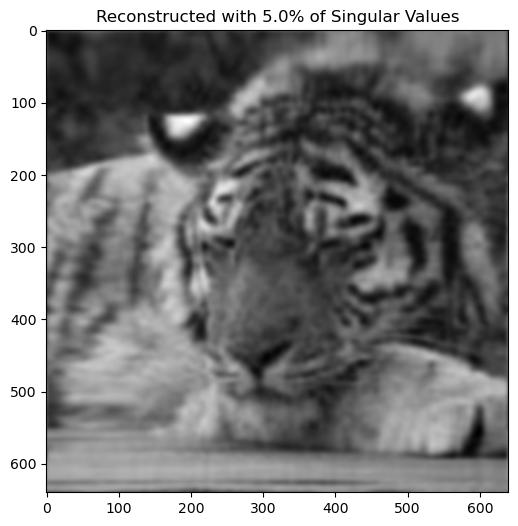

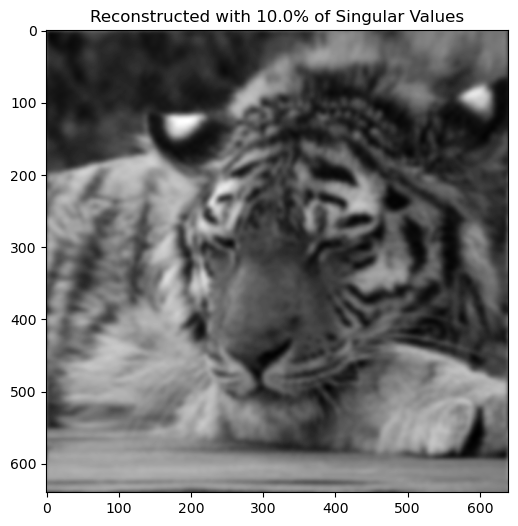

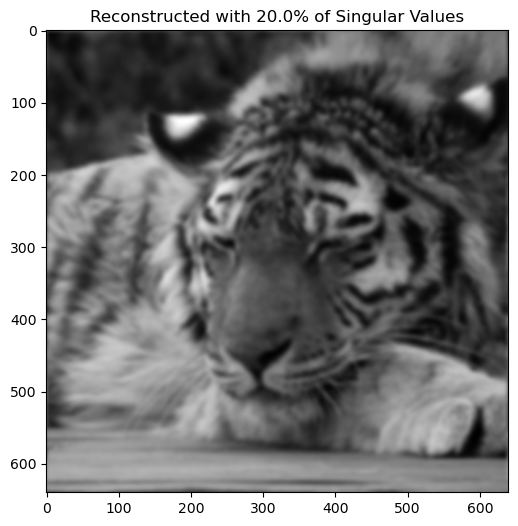

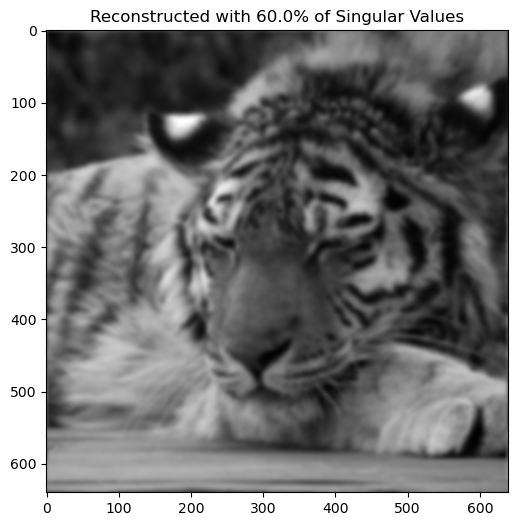

In [11]:
# Define a function to reconstruct the image given the number of singular values to keep
def reconstruct_image_with_truncation(U, s, Vh, num_singular_values_to_keep):
    U_truncated = U[:, :num_singular_values_to_keep]
    Vh_truncated = Vh[:num_singular_values_to_keep, :]
    s_truncated = np.diag(s[:num_singular_values_to_keep])
    return U_truncated @ s_truncated @ Vh_truncated

# Set different truncation levels for demonstration
truncation_levels = [0.05, 0.1, 0.2,0.6]
reconstructed_images = {}

# Perform the reconstruction for each truncation level and display the images
for level in truncation_levels:
    num_to_keep = int(len(s_blurred) * level)
    reconstructed_image = reconstruct_image_with_truncation(U_blurred, s_blurred, Vh_blurred, num_to_keep)
    reconstructed_images[level] = reconstructed_image

    # Display the reconstructed image
    plt.figure(figsize=(6, 6))
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'Reconstructed with {level*100}% of Singular Values')
    plt.show()


In [12]:
# Define a function to calculate PSNR between two images.
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR is 100 by convention.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Calculate PSNR for the reconstructed images with different truncation levels
psnr_values_simulated = {}
for level, reconstructed_image in reconstructed_images.items():
    psnr_value_simulated = calculate_psnr(image_stones, reconstructed_image)
    psnr_values_simulated[level] = psnr_value_simulated
    print(f"PSNR for truncation level {level*100}%: {psnr_value_simulated} dB")

psnr_values_simulated


PSNR for truncation level 5.0%: 23.18066439875533 dB
PSNR for truncation level 10.0%: 23.789470493193363 dB
PSNR for truncation level 20.0%: 23.86501468389854 dB
PSNR for truncation level 60.0%: 23.865945987172204 dB


{0.05: 23.18066439875533,
 0.1: 23.789470493193363,
 0.2: 23.86501468389854,
 0.6: 23.865945987172204}

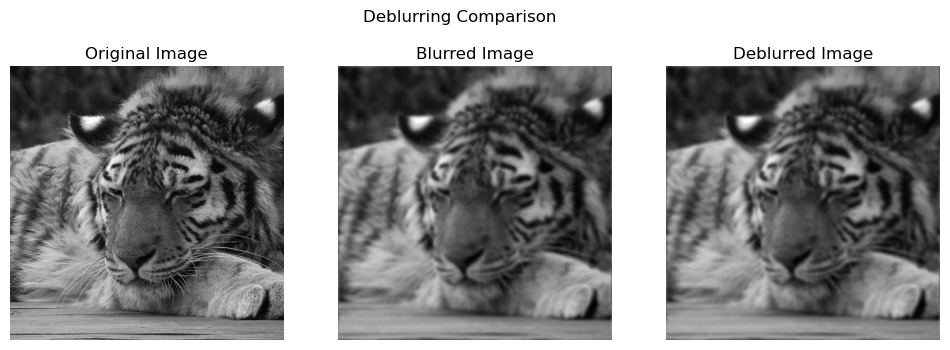

Runtime for deblurring: 0.0020 seconds
PSNR for truncation level 10.0%: 23.789470493193363 dB
Level: 5.0%, Runtime: 0.0020 seconds, PSNR: 23.18066439875533 dB
Level: 10.0%, Runtime: 0.0020 seconds, PSNR: 23.789470493193363 dB
Level: 20.0%, Runtime: 0.0020 seconds, PSNR: 23.86501468389854 dB
Level: 60.0%, Runtime: 0.0100 seconds, PSNR: 23.865945987172204 dB


In [13]:
import numpy as np
import cv2
from scipy.signal import convolve2d
from scipy.linalg import svd
from matplotlib import pyplot as plt
import time


def display_comparisons(original, blurred, deblurred, title):
    """Display the original, blurred, and deblurred images side by side."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(deblurred, cmap='gray')
    plt.title('Deblurred Image')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

def measure_runtime(function, *args):
    """Measure the runtime of a given function."""
    start_time = time.time()
    result = function(*args)
    end_time = time.time()
    return result, end_time - start_time

# Load and blur the image
image_path = './test_images/test_images-3/640_640_tiger.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
blurred_image = convolve2d(original_image, gaussian_kernel, mode='same', boundary='wrap')

# Deblurring and measuring runtime
deblurred_image, runtime = measure_runtime(reconstruct_image_with_truncation, U_blurred, s_blurred, Vh_blurred, num_singular_values_to_keep)

# Display images for visual comparison
display_comparisons(original_image, blurred_image, deblurred_image, "Deblurring Comparison")

# Report findings
print(f"Runtime for deblurring: {runtime:.4f} seconds")
print(f"PSNR for truncation level {num_singular_values_to_keep * 100 / len(s_blurred)}%: {calculate_psnr(original_image, deblurred_image)} dB")

# Add findings for different truncation levels
for level, reconstructed_image in reconstructed_images.items():
    _, runtime = measure_runtime(reconstruct_image_with_truncation, U_blurred, s_blurred, Vh_blurred, int(len(s_blurred) * level))
    psnr = calculate_psnr(original_image, reconstructed_image)
    print(f"Level: {level*100}%, Runtime: {runtime:.4f} seconds, PSNR: {psnr} dB")


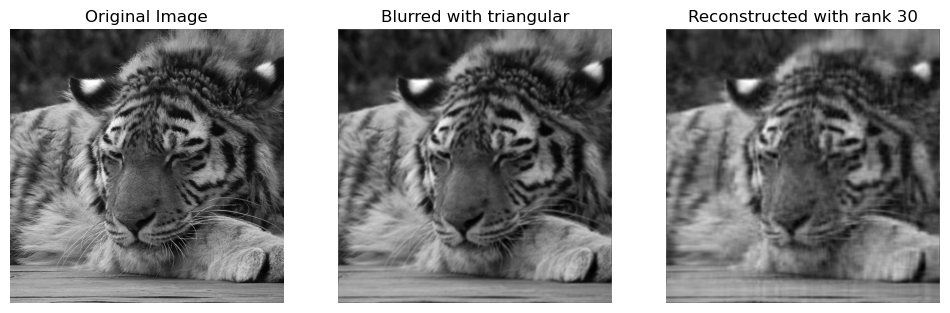

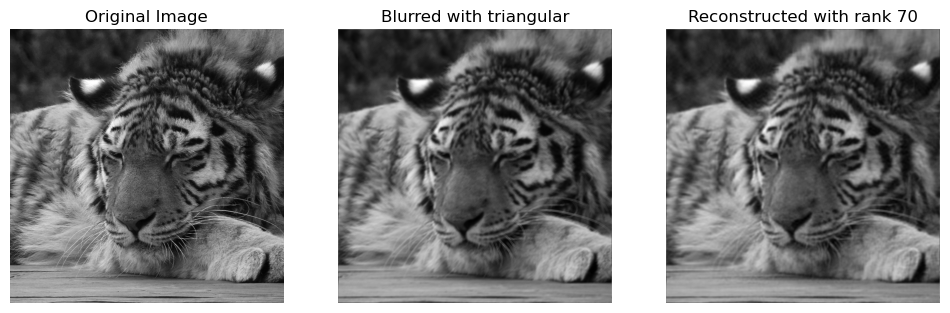

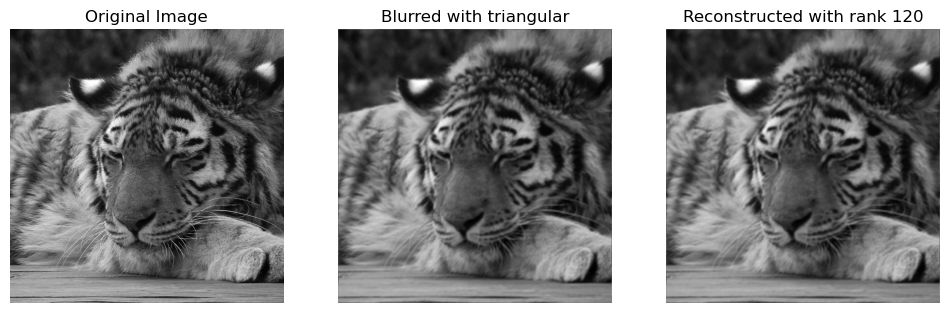

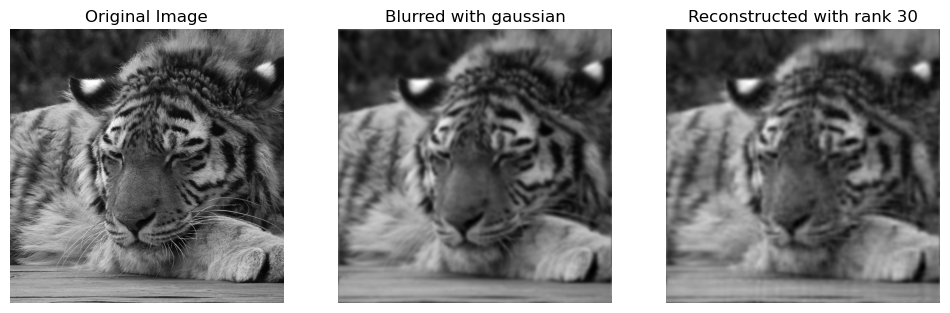

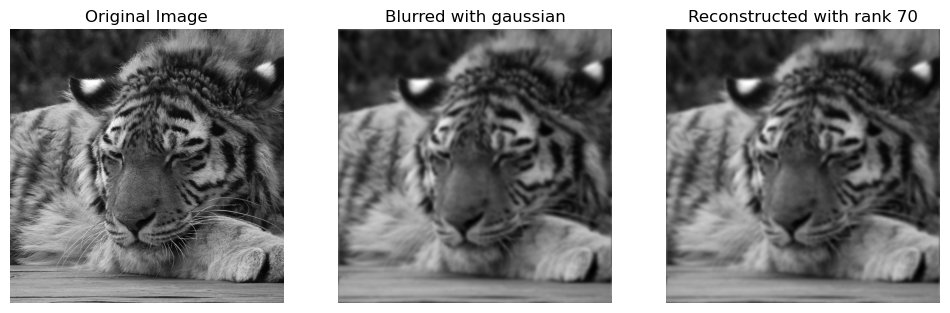

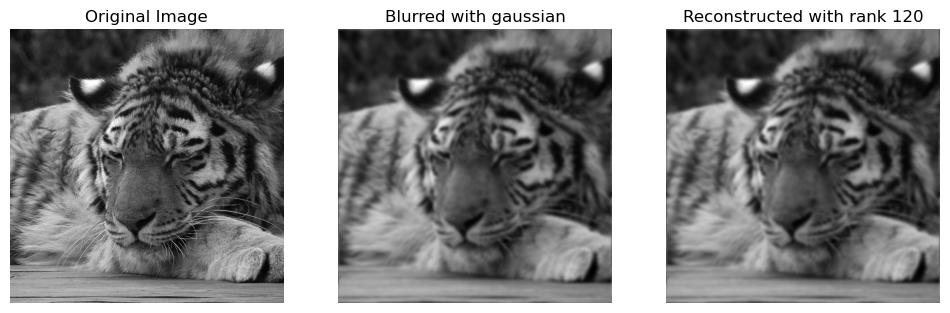

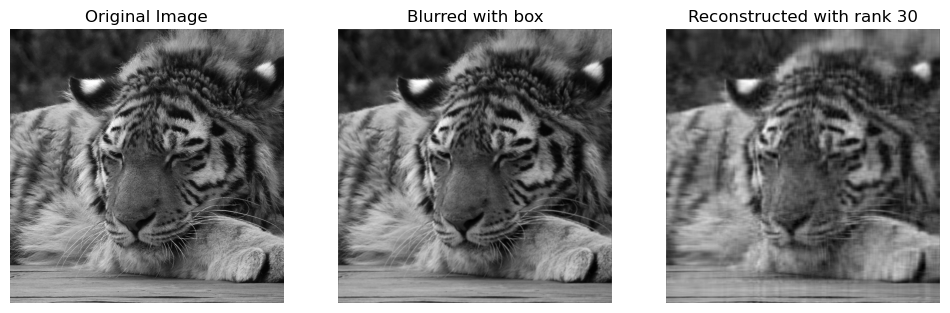

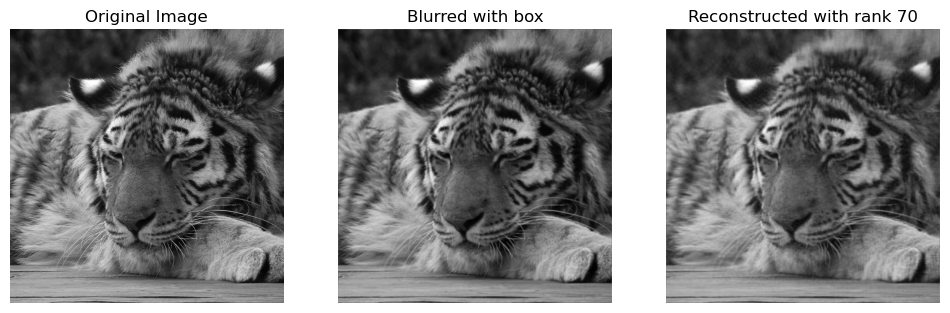

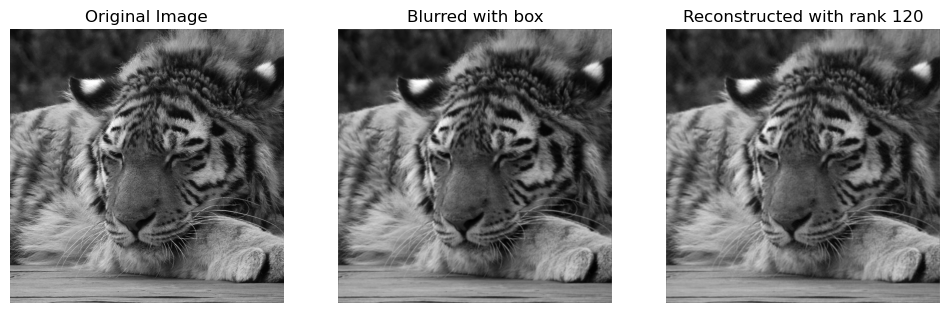

{('triangular', 30): {'blurred': array([[ 97.899994,  81.1     ,  66.049995, ..., 124.3     , 116.350006,
        106.899994],
       [ 80.75    ,  66.35    ,  43.749996, ..., 121.80001 , 109.05    ,
         95.75001 ],
       [ 61.2     ,  38.2     ,  14.799999, ..., 124.75    , 103.950005,
         83.25    ],
       ...,
       [142.75    , 149.45    , 154.90001 , ..., 119.9     , 126.5     ,
        135.59999 ],
       [127.75    , 127.2     , 124.799995, ..., 120.74999 , 127.049995,
        125.899994],
       [111.850006, 105.200005,  95.45    , ..., 123.95001 , 121.75001 ,
        120.50001 ]], dtype=float32), 'reconstructed': array([[ 88.75908 ,  79.437744,  69.37538 , ..., 115.658966, 106.967125,
         97.82226 ],
       [ 74.66617 ,  60.21217 ,  44.948   , ..., 115.36898 , 102.20133 ,
         88.58485 ],
       [ 59.86217 ,  38.079224,  15.424359, ..., 121.76185 , 101.80413 ,
         81.065765],
       ...,
       [139.20538 , 146.42947 , 153.67635 , ..., 118.02755 , 12

In [23]:
def create_triangular_kernel(size):
    """Create a 2D Triangular kernel."""
    kernel = np.tri(size, size, -1, dtype=np.float32) + np.tri(size, size, 0, dtype=np.float32).T - np.eye(size, dtype=np.float32)
    kernel /= kernel.sum()
    return kernel
def create_box_kernel(size):
    """Create a 2D Box blurring kernel."""
    kernel = np.ones((size, size), np.float32) / (size * size)
    return kernel
def load_image(image_path):
    """Load an image as a grayscale 2-D array."""
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Example: Create a 3x3 box blurring kernel
box_kernel = create_box_kernel(3)

# Example: Create a 5x5 triangular blurring kernel
triangular_kernel = create_triangular_kernel(5)
def svd_reconstruction(image, kernel, num_singular_values):
    blurred_image = convolve2d(image, kernel, mode='same', boundary='wrap')
    U, s, Vh = svd(blurred_image)
    reconstructed_image = U[:, :num_singular_values] @ np.diag(s[:num_singular_values]) @ Vh[:num_singular_values, :]
    return blurred_image, reconstructed_image
def display_images(images, titles, figsize=(15, 5)):
    """Display a list of images with their corresponding titles."""
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

def test_reconstruction(image_path, kernel_creators, truncation_ranks):
    original_image = load_image(image_path)
    results = {}

    for kernel_name, create_kernel in kernel_creators.items():
        kernel = create_kernel()  # Create kernel here
        for rank in truncation_ranks:
            blurred, reconstructed = svd_reconstruction(original_image, kernel, rank)
            psnr_value = calculate_psnr(original_image, reconstructed)

            results[(kernel_name, rank)] = {
                'blurred': blurred,
                'reconstructed': reconstructed,
                'psnr': psnr_value
            }

            # Display images
            display_images(
                [original_image, blurred, reconstructed],
                ['Original Image', f'Blurred with {kernel_name}', f'Reconstructed with rank {rank}'],
                figsize=(12, 4)
            )
    return results


# Example usage with kernel creation functions
kernel_creators = {
    'triangular': lambda: create_triangular_kernel(5),
    'gaussian': lambda: create_gaussian_kernel(15, 3),
    'box': lambda: create_box_kernel(3)
}
truncation_ranks = [30, 70, 120]
results = test_reconstruction('./test_images/test_images-3/640_640_tiger.png', kernel_creators, truncation_ranks)
print(results)
